# tutorial 5

Creating new units, synapses, and plants

**NOTE:**
In this tutorial you'll enter code in the Draculab source files. For purposes of the tutorial you may use any conventions you like for naming variables. Notice, however, that `camel_case` is the usual standard.

## Part 1
### Creating a new type of unit

Suppose you want to create a unit that outputs the value $-1$ when the sum of its inputs is below a threshold $\theta$, and outputs $1$ otherwise.  
Because Draculab's units are continuous-time dynamical systems, the unit we'll create is not quite the same as a typical binary unit. Switching the output value from $-1$ to $1$ (and viceversa) will happen gradually, with a time constant $\tau$, and the unit will approach its end values asymptotically. If the $i$-th unit has output $x_i$, then its dynamics are described by:  
$ \dot{x_i} = 
\begin{cases}
-1/\tau \text{  if  } I > \theta , \\
1/\tau \text{  if  } I \leq \theta .
\end{cases} \\
\text{where } I = \sum_j \omega_{ij} x_j. $

Creating a new type of unit can be divided into 3 steps:

1. Register the name of the new unit in `draculab.py`.  
The unit class will be written into `custom_units.py`, where you:  
2. Add the `__init__` method.  
3. Add the `derivatives` (or `dt_fun`) method.

Tor register the name of a new unit type open the `draculab.py` and locate the `unit_types` class, which is an [enum](https://docs.python.org/3/library/enum.html).

In the `unit_type` class we define an attribute with the name of the unit, and assign it a unique integer value to identify it. In the case of our unit, we could call it "binary", and assign it the value 101.

Next, in the `unit_types.get_class` method we need to associate the name of the type (e.g. "binary") with the name of the class implementing it in `custom_units.py`. Once this is done we can create this type of units using `network.create(n, params_dict)`, where the paramters dictionary contains the entry `'type' = unit_types.binary`. In general it is better to have the type name and the name of the class being equal, but for the purpose of this tutorial, the class implementing binary units will be `binary_unit`.

In [ ]:
# The code to be entered in the unit_types class is thus
binary = 101
# among the other unit names, and
elif self == unit_types.binary:
    unit_class = binary_unit
# among the elif statements of the get_class method

Let's now write the class implementing the unit in `custom_units.py`.

In [ ]:
class binary_unit(unit):
    """ The unit type created in tutorial 5. """
    def __init__(self, ID, params, network):
        """ The unit constructor. 
        
        Args:
            ID, params, network: same as in the 'unit' parent class.
            In adittion, params should have the following entries.
            REQUIRED PARAMETERS
            tau: time constant for the update dynamics.
            theta: unit's threshold.
        """
        unit.__init__(self, ID, params, network) # parent's constructor
        self.tau = params['tau']
        self.theta = params['theta']
        
    def derivatives(self, y, t):
        """ Derivative function of the binary unit.
        
        Args:
            y: a 1-element array with the current firing rate.
            t: time when the derivative is evaluated.
        """
        I = self.get_input_sum(t)
        if I < self.theta:
            return (-1. - y[0])/self.tau
        else:
            return (1. - y[0])/self.tau
        
    def dt_fun(self, y, s):
        """ The derivative function used by flat networks.
        
        Args:
            y: a scalar value with the current firing rate.
            s: index used to retrieve the input sum to use.
        """
        I = self.inp_sum[s]
        if I < self.theta:
            return (-1. - y)/self.tau
        else:
            return (1. - y)/self.tau

After changing the source code, you neeed to reset the kernel of the Jupyter notebook and import draculab once more.  
Now the unit is ready to use!

Some comments about the class definition:
* The `__init__` method always begins with `unit.__init__(self, ID, params, network)`. This provides the new unit type with all the functionality of the `unit` class. For more information type `help(unit.__init__)`.
* the `derivatives` method is used by `unit.update`, whereas `unit.flat_update` calls `dt_fun`. It is not necessary to write both methods, but adding them both allows our unit to work in simulations with regular and flat networks.
* The `get_input_sum` method is a utility provided by the `unit` class. It returns the sum of all the inputs received by the unit at a given time, each input multiplied by its corresponding synaptic weight. Moreover, all the inputs are obtained considering their corresponding delays. Other methods provided by the unit class are `get_inputs`, and `get_weights`. These can be used to make the `derivatives` function easier to write and read.
* When the network is flat, the unit will have an `inp_sum` attribute, which provides the scaled sum of inputs at various points in time. `inp_sum[0]` is the input sum at the beginning of the current simulation step. `inp_sum[1]` is the input sum at `min_delay/min_buff_size` time units later, and so forth. Unless we're writing a new integration it is not necessary to understand these details. What's important is to know that `imp_sum[s]` is the input. If for some reason the "raw" inputs are required, these are in the `unit.step_inps` array (see `unit.upd_flat_inp_sum`).
* Unit types that use multiple input ports need to override `unit.get_mp_input_sum` in order to specify how to interpret the inputs that arrive at different ports. Such a thing is not part of this tutorial. 

/home/z/projects/draculab/network.py:840: UserWarning: Integration method odeint subsituted by Forward Euler in some units
  ' subsituted by Forward Euler in some units', UserWarning)


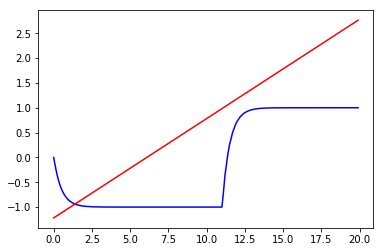

In [1]:
# A quick test of the unit
from draculab import *
from matplotlib import pyplot as plt

# create a network
net_params = { 'min_delay':.1, 'min_buff_size':10}
net = network(net_params)

# create a test unit and an input unit
test_unit_params = {'type': unit_types.binary, #### this is new
               'theta': 1.,
               'tau': 0.5,
               'init_val':0.}
input_unit_params = {'type': unit_types.source,
                     'init_val': -1.,
                     'function': lambda t: -1 + .2*t }
test_unit = net.create(1, test_unit_params)
input_unit = net.create(1, input_unit_params)

# connect them
conn_spec = {'rule': 'one_to_one',
             'delay': 1. }
syn_spec = {'type': synapse_types.static,
            'init_w': 1. }
net.connect(input_unit, test_unit, conn_spec, syn_spec)

# simulate
times, activs, _ = net.run(20.)
#times, activs, _ = net.flat_run(20.)

# plot
fig = plt.figure
plt.plot(times, activs[0], 'b', times, activs[1], 'r')
plt.show()

## Part 2
### Creating a new synapse type

Now let's assume that we want to create a new type of synapse. This synapse will have a weight that will adopt one of two values, -1 or 1 (clearly not biologically realistic). Let $\langle x_{pre} \rangle$ be the average value of the presynaptic activity, and $\langle x_{post} \rangle$ be the average postsynaptic activity. Our synapse will be such that the weigth will move to 1 if $\langle x_{pre} \rangle > \langle x_{post} \rangle$, and to -1 otherwise.

Before we proceed to write the synapse class, we should specify how the average activity is calculated. The average of a continuous function $f$ is usually defined as
$ \frac{1}{T} \int_{t_0}^{t_0 + T} f(s) ds $. Using this type of average for our rule, however, is not very practical; the reason is that it gives the same importance to values that occurred in the distant past compared to recent values. After a while, the values of the average become slower, and slower to respond.

A simple way to obtain an average that places more importance on the most recent values is to use a first order *low-pass filter*. A simple, yet effective version is defined by:
$\frac{d \langle x \rangle}{dt} = \frac{ x - \langle x \rangle }{ \tau_f } $.

Such a quantity can be calculated by the unit and made available to all its synapses if the unit contains a low-pass filter *requirement*. In general, a requirement can be added to a unit if the requirement's name is added to `syn_needs`, which is an object of the *set* data type in the unit. This can be done in the unit's constructor. The name of all available requirements can be seen in the `syn_reqs` enum class of `draculab.py`. Alternatively, they are displayed by the command `syn_reqs.list_names()`. Documentation about a particular requirement can be found in the methods of the `requirements.py`; in particular, in the methods called `add_<requirement name>`.

In the case of requirements used by synapses, it is not necessary to add them in the constructors of the units we'll use. If we specify which requirements will be used by the synapse in its constructor, these will be automatically added to the relevant units by `network.connect`. The code in this example will illustrate this.

Similarly to the case of units, to create the new synapse type we will follow 3 steps:
1. Register the name of the synapse in the synapse_types enum at `draculab.py`. This is basically the same as the first step to create a new unit type.
2. Create the synapse class, with an `__init__` method.
3. Write the function that the synapse uses to update its weight in the `update` method. This method is called every `min_delay` time units during the simulation.

Our new type of synapse will be called *switcher*, and so will its corresponding class.

In [3]:
# In draculab.py you need to write
switcher = 101
# in the synapse_types class, and
elif self == synapse_types.switcher:
        syn_class = switcher
# in the get_class method.

SyntaxError: invalid syntax (<ipython-input-3-7ed4d493a622>, line 4)

In [ ]:
# In synapses.py add this class
class switcher(synapse):
    """ The synapse created in part 2 of tutorial 5. """
    def __init__(self, params, network):
        """ The class constructor. 
        
        Args:
            params: same as the 'synapse' parent class, with these additions
            'lrate': learning rate; a scalar that multiplies the weight's derivative
        """
        synapse.__init__(self, params, network) # calling the parent's constructor
        self.lrate = params['lrate'] # learning rate
        self.upd_requirements = set([syn_reqs.lpf_mid, syn_reqs.pre_lpf_mid])
        self.alpha = self.lrate * self.net.min_delay # factor that scales the update rule 
        
    def update(self, time):
        """ Updates the synaptic weight at each simulation step. """
        pre_avg = self.net.units[self.preID].get_lpf_mid(self.delay_steps)
        post_avg = self.net.units[self.postID].get_lpf_mid(0)
        if pre_avg > post_avg:
            self.w += self.alpha * (1. - self.w)
        else:
            self.w += self.alpha * (-1. - self.w)

In the `__init__` method there is one set called `upd_requirements`. In here you can put any *requirements* you want to have available in the `update` method. The `lpf_mid` method is a first order low-pass filter, which is supposed to have a time constant that is not too fast and not too slow. In practice the user sets any time constant she wants. There are 3 filter *requirements* available, (`lpf_fast`, `lpf_mid`, and `lpf_slow`), and their names are supposed to help keep track of how fast they are compared to each other.

There is another entry in `upd_requirements`, namely `pre_lpf_mid`. This is also a mid-speed low-pass filter, but whereas `lpf_mid` creates the requirement in the postsynaptic unit, `pre_lpf_mid` creates it in the presynaptic unit. In this way we can have a correlational learning rule that uses averaged activities from pre- and post-synaptic units.

The `update` method is rather straightforward, except for the `get_lpf_mid` functions. These are _getter_ functions for the `lpf_mid` value in a unit. Getter functions are often recommended for object-oriented programming, but they are not important in Python. In general, requirements don't need a getter function; there is a variable in the unit whose name matches the requirement name, and it can directly be retrived (e.g. `value = unit.lpf_mid`). In the case of the LPF requirements, however, it is important to have a getter function because we want to retrieve *past* values of the requirement. Since there is a transmission delay, the average value of the *presynaptic* unit is know with that delay. The synapse stores this delay in the `delay_steps` variable, using "time step" time units, where a time step has a `min_delay` duration. The function `get_lpf_mid(n)` returns the value of `lpf_mid` as it was `n` time steps ago. For the postsynaptic unit, where the synapse is supposed to be located, this value is known instantaneously, but for the presynaptic unit it is know after a delay.

Now we need to test our *switcher* synapse in a simulation. Let's combine it with our new binary units.

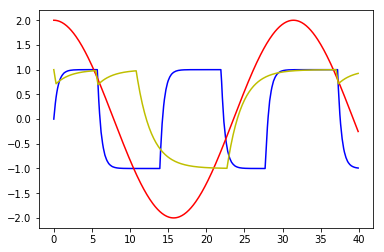

In [1]:
# For the first test we modify the simulation of Part 1 with a different input,
# and insert a 'switcher' synapse. Moreover, we want to observe the weight of
# the synapse, so we introduce a 'tracker' unit.
from draculab import *
from matplotlib import pyplot as plt
from numpy import cos

# create a network
net_params = { 'min_delay':.1, 'min_buff_size':10}
net = network(net_params)

# create a test unit and an input unit
test_unit_params = {'type': unit_types.binary,
               'theta': 1.,
               'tau': 0.5,
               'tau_mid': 0.1, # Needed to get lpf_mid
               'init_val':0.}
input_unit_params = {'type': unit_types.source,
                     'init_val': -1.,
                     'tau_mid': 0.1, # Needed to get lpf_mid
                     'function': lambda t: 2.*cos(.2*t) }
tracker_unit_params = {'type': unit_types.source,
                       'init_val': 1.,
                       'function': lambda t: None }
test_unit = net.create(1, test_unit_params)
input_unit = net.create(1, input_unit_params)
tracker_unit = net.create(1, tracker_unit_params)

# set the tracker unit to record the synaptic weight
net.units[tracker_unit[0]].set_function(lambda t: net.syns[test_unit[0]][0].w)

# connect them
conn_spec = {'rule': 'one_to_one',
             'delay': 1. }
syn_spec = {'type': synapse_types.switcher,
            'init_w': 1.,
            'lrate': 0.5 }
net.connect(input_unit, test_unit, conn_spec, syn_spec)

# simulate
times, activs, _ = net.run(40.)
#times, activs, _ = net.flat_run(40.)

# plot
fig = plt.figure
plt.plot(times, activs[0], 'b', times, activs[1], 'r', times, activs[2], 'y')
plt.show()

### Exercise 1
Make sense of the plot produced by the cell above.

### Exercise 2
Run the simulation with flat_run instead of run.
Is there a difference?
If so, how do you explain it?

## Part 3
### Creating a new plant

Plants are very similar to units, but they may have high-dimensional outputs, which makes their treatment a bit different.

At this point it is probably not instructive anymore to copy-paste code in the right places as in the previous two parts, since the procedure is basically the same. Therefore, we use a plant model already in the source code, and pretend we are creating it. We will "create" the *point_mass* model.

Suppose we have a point mass floating in 2-dimensional space, and suppose it can be pushed in two directions (in an absolute reference frame), described by vectors $\bf{v}_1$ and $\bf{v}_2$. We will set things up so that inputs arriving at port 0 of the plant will push the mass in the direction $\bf{v}_1$, and inputs in port 1 will push it in the direction of $\bf{v}_2$.

As before, creation of the plant involves 3 steps:
1. Registering the plant name in the `plant_models` enum of draculab.py.
2. Writing an `__init__` method.
3. Writing a `derivatives` method.

For step 1, you can check that in the `plant_models` class of `draculab.py` there are lines:

    point_mass_2D = 2
    . . .
    elif self == plant_models.point_mass_2D:
        plant_class = point_mass_2D

The function of these is the same as in the previous parts.

### Exercise 3. The __init__ method.

In this exercise you'll be asked to write the `point_mass_2D.__init__` method. The solution of the exercise is, of course, the source code in `plants.py`.

There is a lot of freedom regarding the data that you can put into a plant object, but there are 3 attributes that are mandatory in the parameters dictionary given to the `plant` constructor: the `type` of the unit, the `dimension` of the plant's ODE model, and the input dimensionality (`inp_dim`). The `dimension` and `inp_dim` attributes are not something that the user should specify in the parameter dictionary, since these are fixed. 

The first thing that the `__init__` method of `point_mass_2D` does is to fix the values of `dimension` and `inp_dim`.  
Then it calls its parent constructor.  
Next it sets the value of the `init_state` vector, which is a Numpy 1D array with the initial values of the state variables.  
Finally, the `buffer` array is created. This is a 2D Numpy array. Its number of rows is the `buff_width` variable set by the parent constructor, and each row is a copy of the `init_state` vector.

The exercise is to write the `__init__` method, with the steps outlined above, and the initialization of any other required attributes.

In [ ]:
class point_mass_2D(plant):
    """ A point mass moving in two dimensions, with force exerted by the inputs. 
    
        Inputs may arrive at ports 0 or 1.
        Inputs at port 0 push the mass in the direction of 'vec0' with a force
        equal to the input activity times the synaptic weight times a 'g0' gain
        parameter. 
        Inputs at port 1 push the mass in the direction of 'vec1' with a force
        equal to the input activity times the synaptic weight times a 'g1' gain
        parameter.
        
        Mass is in units of kilograms, distance in meters, force in Newtons,
        time in seconds. Position is specified in Cartesian coordinates.
    """
    def __init__(self, ID, params, network):
        """ The class constructor. 
        
        Args:
            ID: an integer serving as a unique identifier in the network
            network: the network containing the plant
            params: a dictionary with parameters to initialize the model
            REQUIRED PARAMETERS
                type: this should have the plant_models.point_mass_2D value.
                mass: mass in kilograms.
                init_pos: a 2-element array-like with the initial (x,y) position.
                init_vel: a 2-element array-like with the initial (x,y) velocity.
                vec0: 2-element array-like with direction of force for port 0 inputs.
                vec1: 2-element array-like with direction of force for port 1 inputs.
                g0: force in Newtons exerted by an input sum of magnitude 1 at port 0.
                g1: force in Newtons exerted by an input sum of magnitude 1 at port 1.
        """
        # This is the stuff that goes into all model constructors. Adjust accordingly. 
        #-------------------------------------------------------------------------------
        
        
        #-------------------------------------------------------------------------------
        # Initialize the parameters specific to this model
        

### Exercise 4. The derivatives method.
The derivatives method is simple once you know how to obtain the inputs.

`self.get_input_sum(t,0)` retrieves the sum of inputs from port 0 at time `t`.
`self.get_input_sum(t,1)` retrieves the sum of inputs from port 1 at time `t`.

Using this write the `derivatives` method.

In [5]:

    def derivatives(self, y, t):
        """ Returns the derivtives of the state variables at time 't'. 
        
        Args:
            y[0]: x-coordinate [meters]
            y[1]: y-coordinate [meters]
            y[2]: x-velocity [meters / second]
            y[3]: y-velocity [meters / second]
            t: time when the derivative is evaluated [seconds]
        Returns:
            4-element Numpy array with [x_vel, y_vel, x_accel, y_accel]
        """

        

(4, 3)

**NOTE:** Nothing extra has to be done in order to make the plant compatible with flat networks. In a flat network the model is integrated with `solve_ivp` instead of `odeint`, but this is transparent to the user.

In [2]:
"""
To learn to set the plant's inputs,
it helps to look at the documentation.
"""
help(network.set_plant_inputs)

Help on function set_plant_inputs in module network:

set_plant_inputs(self, unitIDs, plantID, conn_spec, syn_spec)
    Set the activity of some units as the inputs to a plant.
    
    Args:
        unitIDs: a list with the IDs of the input units
        plantID: ID of the plant that will receive the inputs
        conn_spec: a dictionary with the connection specifications
            REQUIRED ENTRIES
            'inp_ports' : A list. The i-th entry determines the input type of
                          the i-th element in the unitIDs list.
            'delays' : Delay value for the inputs. A scalar, or a list of length len(unitIDs)
                       Delays should be multiples of the network minimum delay.
        syn_spec: a dictionary with the synapse specifications.
            REQUIRED ENTRIES
            'type' : one of the synapse_types. Currently only 'static' allowed, because the
                     plant does not update the synapse dynamics in its update method.
       

In [1]:
# A quick test of the point_mass_2D plant model.
# We want the point mass to move in a circle using two inputs.
from draculab import *
from matplotlib import pyplot as plt
from numpy import cos, sin

# create a network
net_params = { 'min_delay':.1, 'min_buff_size':10}
net = network(net_params)

# create a point_mass_2D instance
plant_params = {'type': plant_models.point_mass_2D,
                'mass': 1.,
                'init_pos': (1., 0.),
                'init_vel': (0., 1.),
                'vec0': (1., 0.),
                'vec1': (0., 1),
                'g0': 1.,
                'g1': 1. }
pm = net.create(1, plant_params)

# create inputs to the plant. A sine and a cosine
input_unit_params = {'type': unit_types.source,
                     'init_val': -1.,
                     'tau_mid': 0.1, # Needed to get lpf_mid
                     'function': lambda t: -np.sin(t) }
input_units = net.create(2, input_unit_params)
net.units[input_units[1]].set_function(lambda t: np.cos(t))

# connect
conn_spec = {'inp_ports': [0, 1],
             'delays': [0.5, 0.5] }
syn_spec = {'type': synapse_types.static,
            'init_w': 1. }
net.set_plant_inputs(input_units, pm, conn_spec, syn_spec)

# simulate
times, activs, st_vars = net.run(10.)

### SOLUTION TO EXERCISE 1
What is observed is just what we programmed.

When the input (presynaptic activity, red line) is larger than the postsynaptic activity (e.g. red line above blue line) the weight (yellow line) starts to grow after a tiny delay, approaching the value 1. When the blue line is above the red line then the weight approaches -1.

### SOLUTION TO EXERCISE 2
You should be able to observe a small difference at latter times in the simulation. Since no integration method was specified in the parameters of the binary unit, `odeint` is used by default. This integratator uses adaptive steps size and automatically switches between methods in order to achieve a desired accuracy. For details, se the notes on the "lsoda" integrator [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode). In our case, the accuracy of integration used by `odeint` is set by the network parameters `atol` and `rtol`. These two were not explicitly written in the `net_params` dictionary, so they adopted their default $10^{-6}$ value, which is very precise (and relatively slow).

On the other hand, when this tutorial was written, draculab would by default use a forward Euler integrator when `flat_run` was called. The forward Euler method has an error that depends linearly on the step size. Despite its simplicity and speed it can be very inaccurate, and even unstable for certain ODE systems. Therefore, in a simulation with the forward Euler solver it is important to be aware of that the step size is `min_delay`/`min_buff_size`, and that it is good practice to corroborate results using smaller step sizes, or a different solver.

In the case of the synapse, its `update` method is in effect a forward Euler solver. This is acceptable when the synapse changes slowly compared to the `min_delay` value. If there was a case where this wasn't true, the synapse would need a more accurate integration method in its `update` function.